<a href="https://colab.research.google.com/github/grmtveeen/Binary-Golay-Coder-Decoder/blob/main/Data_symmetrical_4D_change_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy import*
from sympy import*
import sympy as sym
import matplotlib.pyplot as plt
import time
import numpy as np
import plotly.graph_objects as go
import numpy as np
from google.colab import files


N = 1000                   #количество атомом для статистики
K = 39.47841760435742   #характерная константа
W=1                     #ширина пинцета

In [ ]:
def pp (x, vector):
        res = 0
        for i in range(len(vector)):
                res += (vector[i] / (i + 1)) * (x**(i + 1))
        return res

In [ ]:
def dp(x, vector): #профиль скорости (производная плинома)
        res=0;
        for i in range(len(vector)):
                res += vector[i] * (x**(i))
        return res

In [ ]:
def Polynome(x, vector, tEnd, s): #профиль перемещения (полином)
        if x < tEnd/2: return np.vectorize(float)(s/2 - pp(tEnd/2 - x, vector))
        else         : return np.vectorize(float)(s/2 + pp(x - tEnd/2, vector))

In [ ]:
def dPolynome(x, vector, tEnd): #профиль перемещения (полином)
        if x < tEnd/2: return np.vectorize(float)( dp(tEnd/2 - x, vector))
        else         : return np.vectorize(float)( dp(x - tEnd/2, vector))

In [ ]:
def f(t, y, tEnd, s, vector): # функция правых частей системы ОДУ       
         f = np.zeros([4])
         f[0]=y[1]    
         f[1]=-K*(y[0]-Polynome(t,vector,tEnd,s))*np.exp(-((y[0]-Polynome(t,vector,tEnd,s))**2+y[2]**2)/(W**2))
         f[2]=y[3]
         f[3]=-K*y[2]*np.exp(-((y[0]-Polynome(t,vector,tEnd,s))**2+y[2]**2)/(W**2))
         return f

In [ ]:
def rungeKutta(f, to, yo, tEnd, s, tau, vector):
         def increment(f, t, y, tau,vector):# поиск приближённого решения методом Рунге—Кутта—Фельберга.
                  k1=tau*f(t,y,tEnd,s,vector)
                  k2=tau*f(t+(1/4)*tau,y+(1/4)*k1,tEnd,s,vector)
                  k3 =tau *f(t+(3/8)*tau,y+(3/32)*k1+(9/32)*k2,tEnd,s,vector)
                  k4=tau*f(t+(12/13)*tau,y+(1932/2197)*k1-(7200/2197)*k2+(7296/2197)*k3,tEnd,s,vector)
                  k5=tau*f(t+tau,y+(439/216)*k1-8*k2+(3680/513)*k3 -(845/4104)*k4,tEnd,s,vector)
                  k6=tau*f(t+(1/2)*tau,y-(8/27)*k1+2*k2-(3544/2565)*k3 +(1859/4104)*k4-(11/40)*k5,tEnd,s,vector)
                  return (16/135)*k1+(6656/12825)*k3+(28561/56430)*k4-(9/50)*k5+(2/55)*k6     
         t = []#подготовка пустого списка t
         y = []#подготовка пустого списка y
         t.append(to)#внесение в список t начального значения to
         y.append(yo)#внесение в список y начального значения yo
         while to < tEnd:#внесение результатов расчёта в массивы t,y
                  tau = min(tau, tEnd - to)#определение минимального шага tau
                  tau = float(tau)
                  yo = yo + increment(f, to, yo, tau,vector) # расчёт значения в точке t0,y0 для задачи Коши
                  to = to + tau # приращение времени
                  t.append(to) # заполнение массива t
                  y.append(yo) # заполнение массива y       
         return array(t), array(y)

In [ ]:
def energy(y,t,η,tEnd,s,vector):  #вычисление энергии атома в пинце в момент остановки
        res = ((y[-1][1])**2+y[-1][3]**2)-K*np.exp(-((y[-1][0]-Polynome(t[-1],vector,tEnd,s))**2+y[-1][2]**2)/(W**2)); #значение энергии
        if res <= -η*K:
              return res 
        return None

In [ ]:
def energy_start(y,t,tEnd,s,vector):  #вычисление энергии атома в пинце в момент перед стартом
        return ((y[0][1])**2+y[0][3]**2)-K*np.exp(-((y[0][0]-Polynome(t[0],vector,tEnd,s))**2+y[0][2]**2)/(W**2));

In [ ]:
def energy_stop(y,t,tEnd,s,vector):  #вычисление энергии атома в пинце в момент остановки
        return ((y[-1][1])**2+y[-1][3]**2)-K*np.exp(-((y[-1][0]-Polynome(tEnd,vector,tEnd,s))**2+y[-1][2]**2)/(W**2)); #значение энергии

In [ ]:
def get_tEnd(sEnd,vecotor): #вычисляет время за которое атом переместится на sEnd при выбранном vector
        x = sym.Symbol('x')
        eq = sym.Eq(pp(x,vecotor), sEnd/2)
        sol = sym.solve(eq)
        res = []
        ans = []
        print(sol)
        for s in sol:
              if s.is_real:
                   res.append(s.evalf())
        for i in range(len(res)):
              if res[i] > 0:
                    ans.append(res[i])
        if not ans:
              return None
        return 2 * min(ans)

In [ ]:
def newton_search(a, b, EPS, s, vector):
      Xnn = 3 * EPS 
      Xn = b
      X = EPS
      while (abs(Xnn - X) > EPS): 
          X = Xn
          Xnn = Xn - ((pp(Xn, vector) - s) / dp(Xn, vector))
          Xn = Xnn
      return Xnn;

In [ ]:
def get_tEnd_2 (sEnd, vector):
        t = 0
        tau = 0.1
        Tmax = 30
        while (t < Tmax):
            if (tau >= (Tmax - t)): tau = Tmax - t
            if((pp(t,vector) - sEnd/2) * (pp(t + tau,vector) - sEnd/2) <= 0):
                return 2 * newton_search(t, t + tau, 1e-6, sEnd/2, vector)
            if (pp(t,vector) > pp(t + tau,vector)): return -1
            t += tau
        return -1

In [ ]:
def solve_function(sEnd,vector): #функция, которую минимизируем
      to = 0                # начальный момент отсчёта времени
      yo = array([0,0,0,0]) # начальные условия атома в пинцете
      tau =0.01 # шаг
      η=0    # уровень максимальной энергии
      tEnd = get_tEnd_2(sEnd,vector)
      if tEnd is None:
            #raise MyCustomError('IncorrectProfile')
            return None
      t, y = rungeKutta(f, to, yo, tEnd, sEnd, tau, vector)
      E = energy(y,t,η,tEnd,sEnd,vector)
      if E is None:
            #raise MyCustomError('EnergyLoss')
            return None
      return array(t), array(y), tEnd, E

In [ ]:
def solve_function_init_conditions(sEnd,vector,tEnd,conditions): #функция, которую минимизируем
      to = 0                # начальный момент отсчёта времени
      yo = array(conditions) # начальные условия атома в пинцете
      tau =0.01 # шаг
      η=0    # уровень максимальной энергии
      t, y = rungeKutta(f, to, yo, tEnd, sEnd, tau, vector)
      return array(t), array(y)

In [ ]:
#Color array for atoms
colors = []
for i in range(N):
    colors.append((np.random.random(), np.random.random(), np.random.random()))

In [ ]:
def get_heating(s,t,tEnd,N,y_res,vector):
  Energy_start = []
  Energy_stop = []
  for i in range(N):
      Energy_start.append(energy_start(y_res[i],t,tEnd,s,vector))
      Energy_stop.append(energy_stop(y_res[i],t,tEnd,s,vector))

  return 100*(sum(Energy_start)-sum(Energy_stop))/sum(Energy_start)

In [ ]:
#3mkm 35K 1.356068        -39.478418      1.000000        -38.413415      1.335518        37.569503       -186.262749     214.089344
#7.900000	1.798231 -39.478417 1.000000 -37.778653 0.197306 77.727154 -233.639479 177.267180
def get_graphs(data_vector, T, Maxwell, Bolcman):
  #Get solve

  print("T = " + str(T) + " mkK")
  print("Tend = " + str(data_vector[1] * 3.838986523460431) + " mks")
  print("Avarage speed = " + str(data_vector[0] / (data_vector[1] * 3.838986523460431)) + " m/s")

  #Initialize Profile
  vector = [data_vector[i] for i in range(5,len(data_vector))]
  print("Polynomial coefficients = " + str(vector))


  #Create N atoms woth random conditions
  Vx0 = np.random.normal(0, Maxwell, N)
  X0 = np.random.normal(0, Bolcman, N)
  Y0 = np.random.normal(0, Bolcman, N)
  Vy0 = np.random.normal(0, Maxwell, N)

  y_res = []
  Y_res = []
  dY_res = []
  t = []
  

  for i in range(N):
      t, y = solve_function_init_conditions(data_vector[0], vector, data_vector[1], [X0[i],Vx0[i],Y0[i],Vy0[i]])
      y_res.append(y)
      
  for coordinates_arr in y_res:
        Y_res.append([element[0] for element in coordinates_arr])

  for coordinates_arr in y_res:
        dY_res.append([element[1]/3.838986523460431 for element in coordinates_arr])

  #create t array
  t = []
  to = 0
  tau = 0.01
  t.append(to)
  while to < data_vector[1]:
          tau = min(tau, data_vector[1] - to)
          tau = float(tau)
          to = to + tau
          t.append(to)

  #Print heating
  Energy_start = []
  Energy_stop = []
  for i in range(N):
      Energy_start.append(energy_start(y_res[i],t,data_vector[1],data_vector[0],vector))
      Energy_stop.append(energy_stop(y_res[i],t,data_vector[1],data_vector[0],vector))

  print("Heating = " + str(get_heating(data_vector[0],t,data_vector[1],N,y_res,vector)) + " % from start average energy")

  #Profile
  t = np.array([element * 3.838986523460431 for element in t])
  time_P = np.linspace(0,float(data_vector[1]),1000)
  y_P = np.array([Polynome(t,vector,data_vector[1],data_vector[0]) for t in time_P])
  y_dP = np.array([dPolynome(t,vector,data_vector[1]) for t in time_P]) / 3.838986523460431
  time_P = time_P * 3.838986523460431


  #Plot graphs
  plt.figure(figsize=(12,5));
  for i in range(N):
      plt.plot(t, Y_res[i], linewidth=0.3, color=colors[i])
  plt.plot(time_P, y_P, linewidth=2, color='blue', label='Траектория центра пинцета')
  plt.xlim([0, t[-1]])
  plt.ylim([-1, max(8,max(y_P))+1])
  #plt.fill_between(time_P, y_P + 1 / np.sqrt(2), y_P - 1 / np.sqrt(2), color='blue', alpha=0.1, label='Область между Fmax')
  plt.fill_between(time_P, y_P + 1, y_P - 1, color='red', alpha=0.1, label='Ширина пинцета w=1мкм')
  plt.xlabel("Время перемещения t, мкс")
  plt.ylabel("Координата x(t), мкм")
  plt.yticks(rotation=90)
  plt.legend()
  plt.grid()
  #plt.savefig("coordinate.png",dpi=600)
  #files.download("coordinate.png")
  plt.show()

  plt.figure(figsize=(6,4));
  for i in range(N):
      plt.plot(t, dY_res[i], linewidth=2, color=colors[i])
  plt.plot(time_P, y_dP, linewidth=2, color='blue', label='Профиль скорости')
  plt.xlim([0, t[-1]])
  plt.ylim([- 0.5, 3])
  plt.xlabel("Время перемещения t, мкс")
  plt.ylabel("Скорость V(t), м/с")
  plt.yticks(rotation=90)
  plt.legend()
  plt.grid()
  #plt.savefig("profile.png",dpi=600)
  #files.download("profile.png")
  plt.show()

In [ ]:
#get_graphs(data4D_10, 1.439599, 1, 10, 0.11874104117237258, 0.01889822365046136)
#get_graphs(data4D_20, 1.639051, 1, 20, 0.1679251908362714, 0.026726124191242442)
#get_graphs(data4D_30, 1.737637, 1, 30, 0.20566551625417723, 0.032732683535398856)
#get_graphs([7, 2.924147, -39.478418, 1.000000, -37.816236, 4.409874*2, 19.165283*(2**2), -38.663222*(2**3), 17.811288*(2**4)],35, 0.22214414690791826, 0.035355339059327376)
get_graphs([14.000000, 2.924147, -39.478418, 1.000000, -37.816236, 4.409874, 19.165283, -38.663222, 17.811288],35, 0.22214414690791826, 0.035355339059327376)
#5.000000	1.548565 -39.478418 1.000000 -38.275368 1.429672 49.569429 -193.364319 183.115768
#get_graphs([8.100000,1.779505, -39.478413, 1.000000, -37.975465, 0.533417, 77.912423, -235.819008, 179.371538],35, 0.22214414690791826, 0.035355339059327376)
#plt.savefig("area.png",dpi=600)
#files.download("area.png")
'''
#T = 10mkK best
tEnd = 1.439599
P = 1
Maxwell = 0.11874104117237258
Bolcman = 0.01889822365046136
'''
'''
#T = 20mkK best
tEnd = 1.639051
P = 1
Maxwell = 0.1679251908362714
Bolcman = 0.026726124191242442
'''

'''
#T = 30mkK best
tEnd = 1.737637
P = 1
Maxwell = 0.20566551625417723
Bolcman = 0.032732683535398856
'''

'''
#T = 35mkK best
tEnd = 1.762408#1.780033
P = 1
Maxwell = 0.22214414690791826
Bolcman = 0.035355339059327376
'''

'''
#T = 40mkK best
tEnd = 
P = 1
M.axwell = 0.23748208234474516
Bolcman = 0.03779644730092272
'''

'''
#T = 50mkK best
#tEnd = 
#P = 1
#Maxwell = 0.26551303978052637
#Bolcman = 0.042257712736425826
'''

T = 35 mkK
Tend = 6.831495713430454 mks
Avarage speed = 1.185684707973353 m/s
Polynomial coefficients = [0.533417, 77.912423, -235.819008, 179.371538]
Heating = 0.05363829076791028 % from start average energy


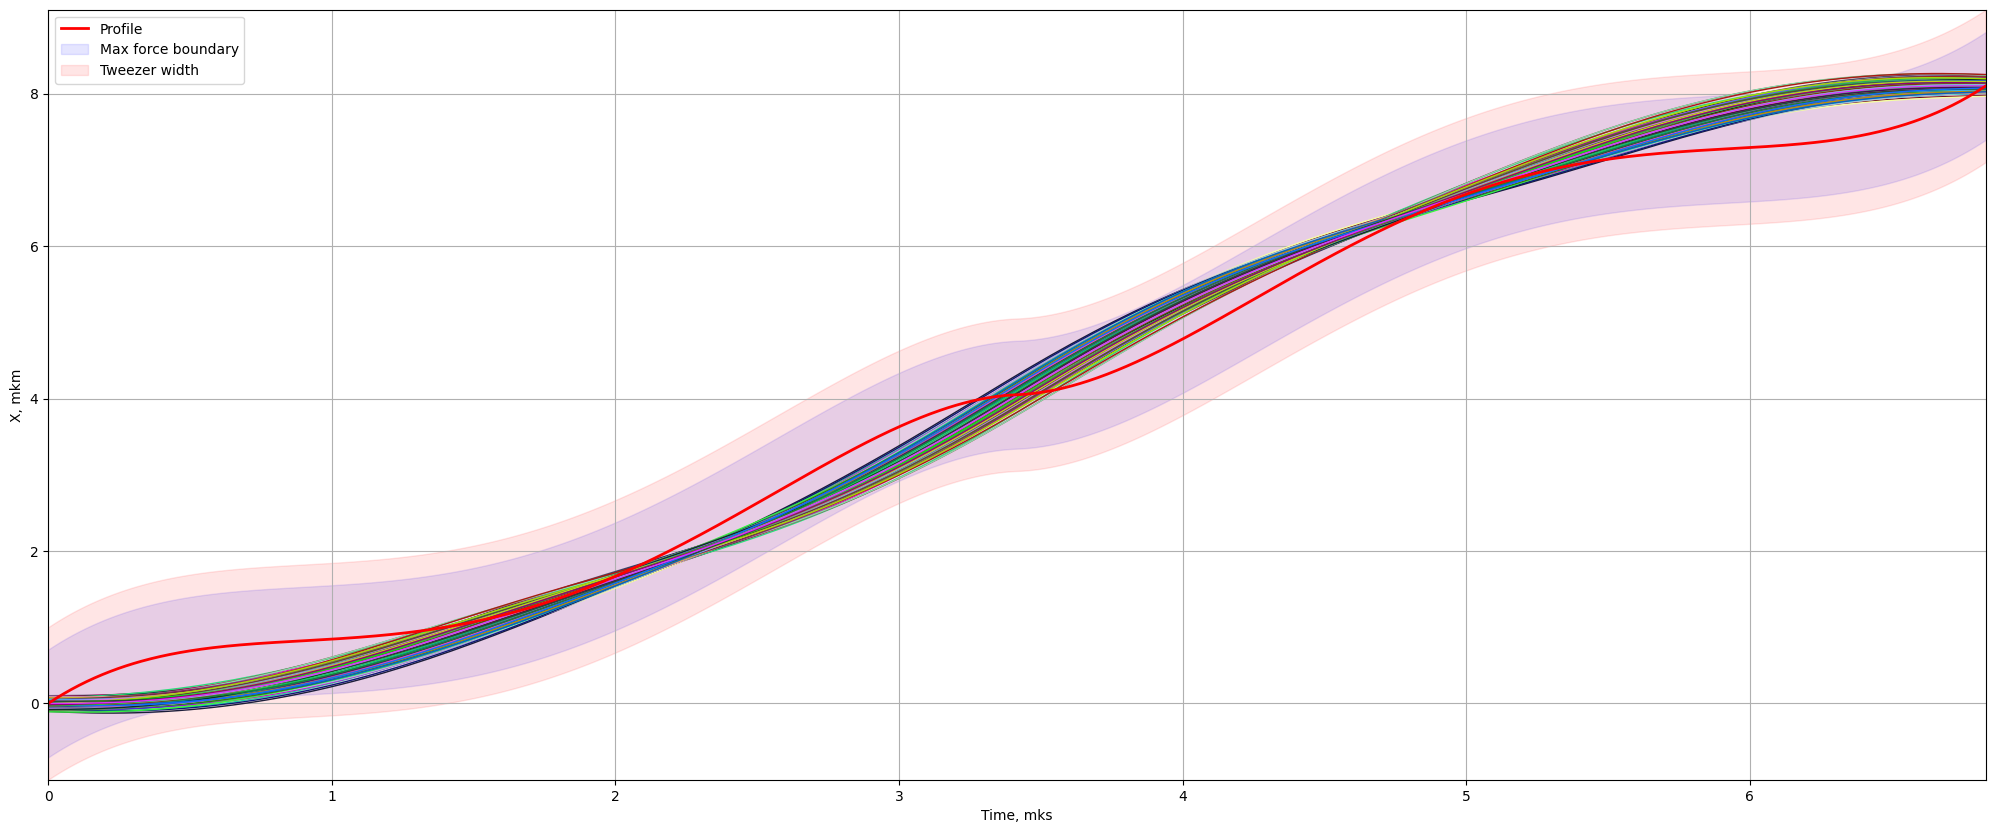

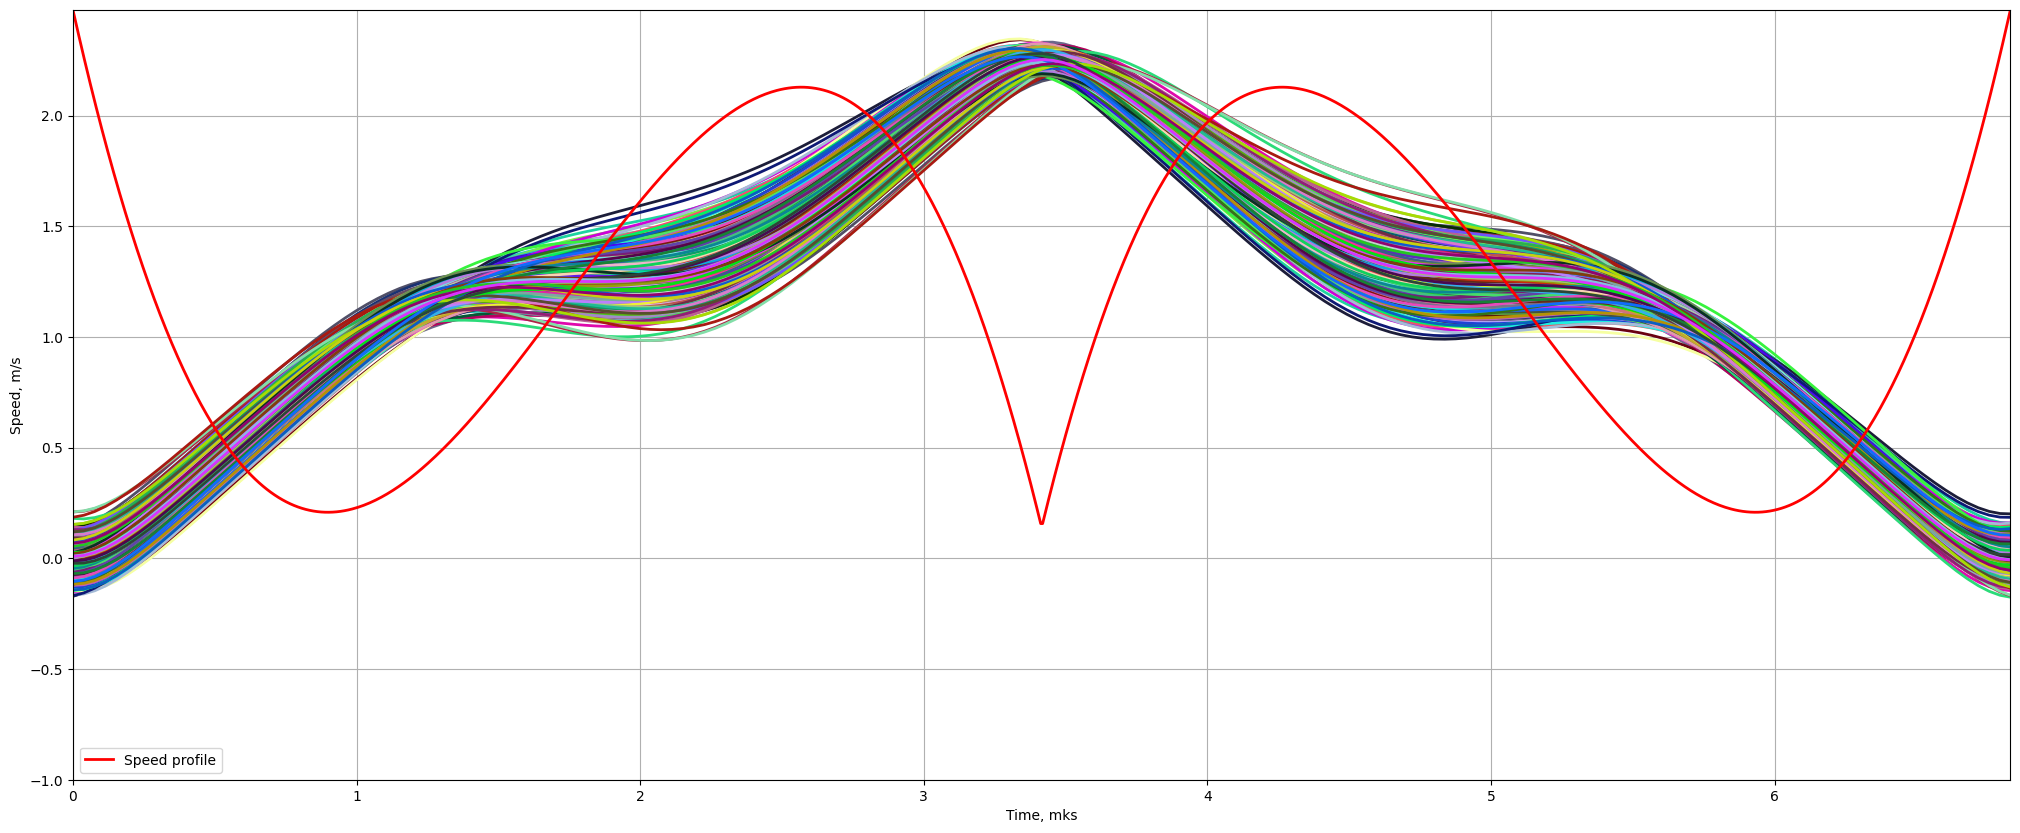

T = 35 mkK
Tend = 7.839436981111084 mks
Avarage speed = 1.3393819001669982 m/s
Polynomial coefficients = [3.007554, 51.97155, -142.69515, 94.656585]
Heating = 0.8004181696305133 % from start average energy


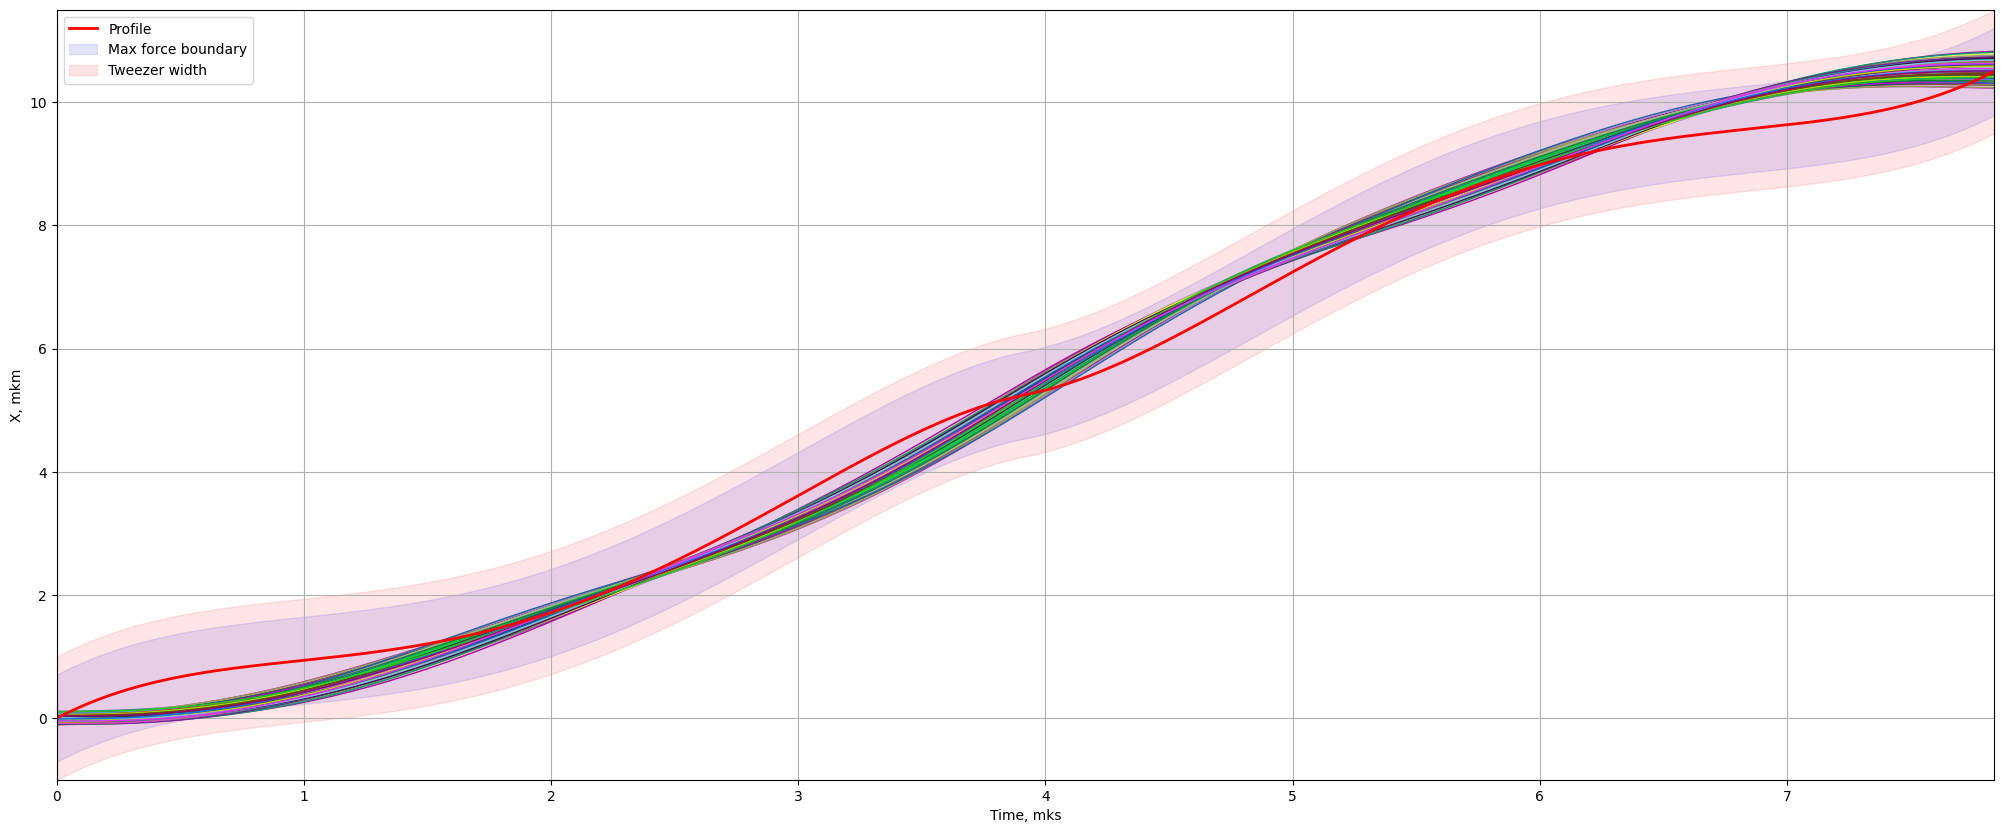

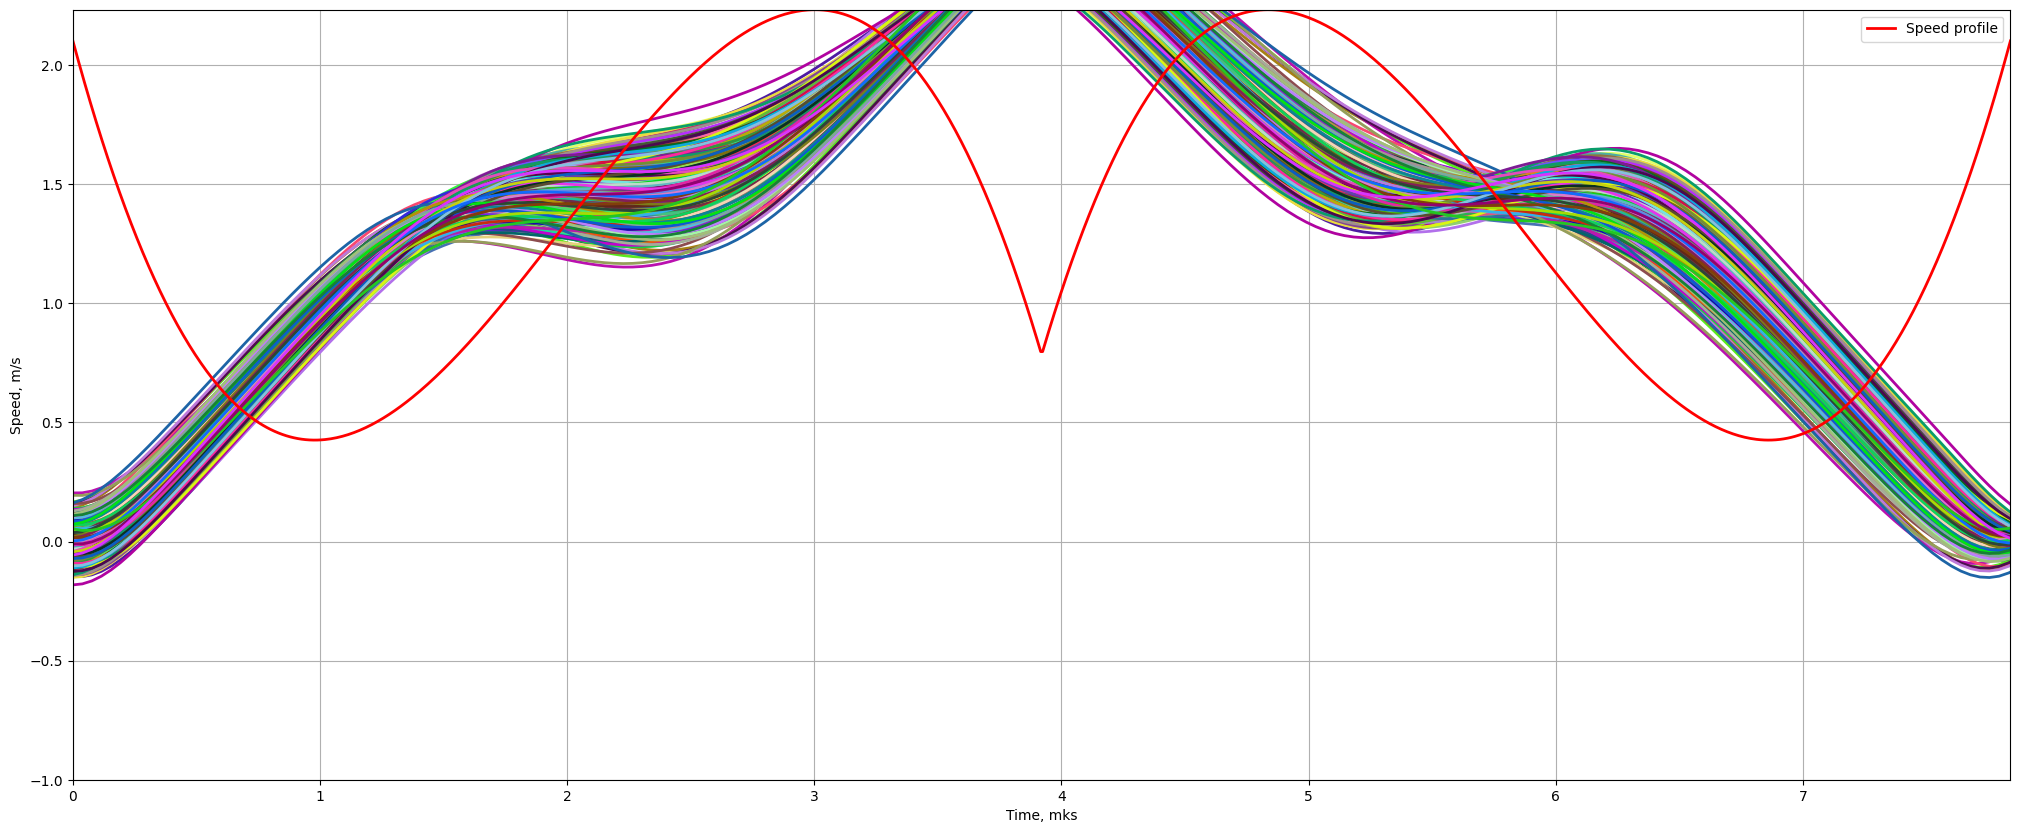

T = 35 mkK
Tend = 11.595574336408715 mks
Avarage speed = 1.1987332060263427 m/s
Polynomial coefficients = [3.499513, 19.738938, -36.589091, 16.274678]
Heating = 0.3781664127916753 % from start average energy


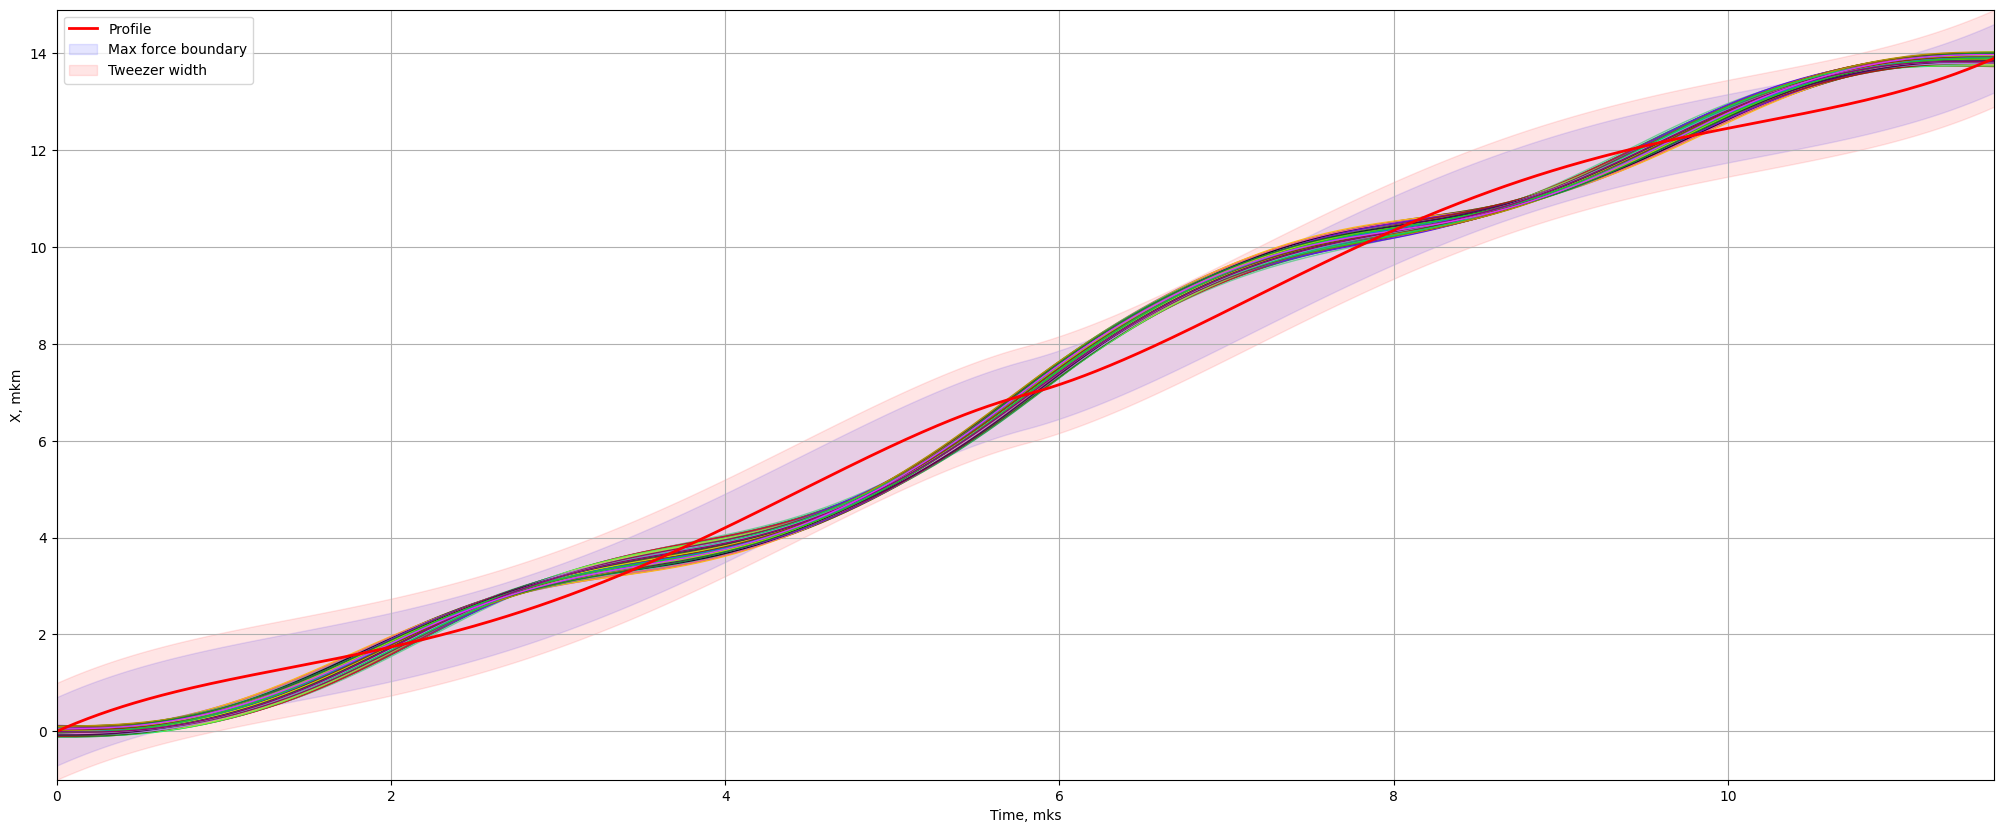

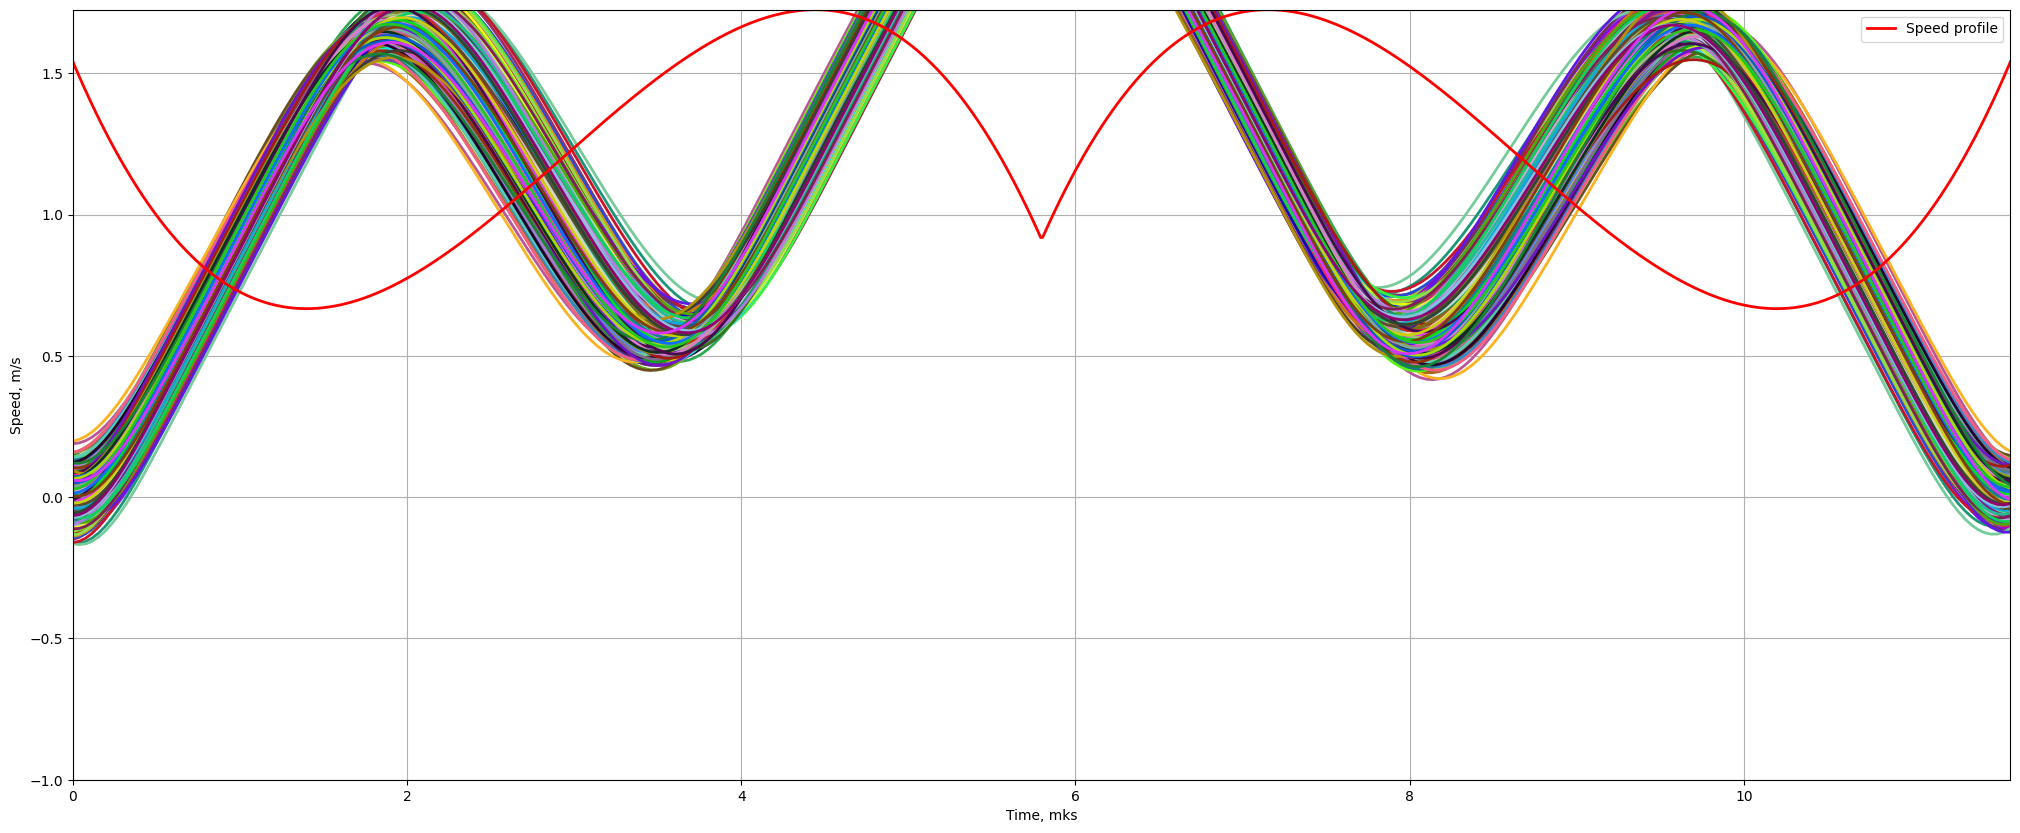

In [ ]:
get_graphs([8.100000,	1.779505, -39.478413, 1.000000, -37.975465, 0.533417, 77.912423, -235.819008, 179.371538],35, 0.22214414690791826, 0.035355339059327376)
get_graphs([10.500000,      2.042059, -39.478417, 1.000000, -37.578170, 3.007554, 51.971550, -142.695150, 94.656585],35, 0.22214414690791826, 0.035355339059327376)
get_graphs([13.900000,     3.020478, -39.478132, 1.000000, -38.310119, 3.499513, 19.738938, -36.589091, 16.274678],35, 0.22214414690791826, 0.035355339059327376)

T = 35 mkK
Tend = 5.560514767135363 mks
Avarage speed = 0.539518394543447 m/s
Polynomial coefficients = [0.6912, 38.850753, -168.382466, 176.389313]
Heating = 0.04594460768404858 % from start average energy


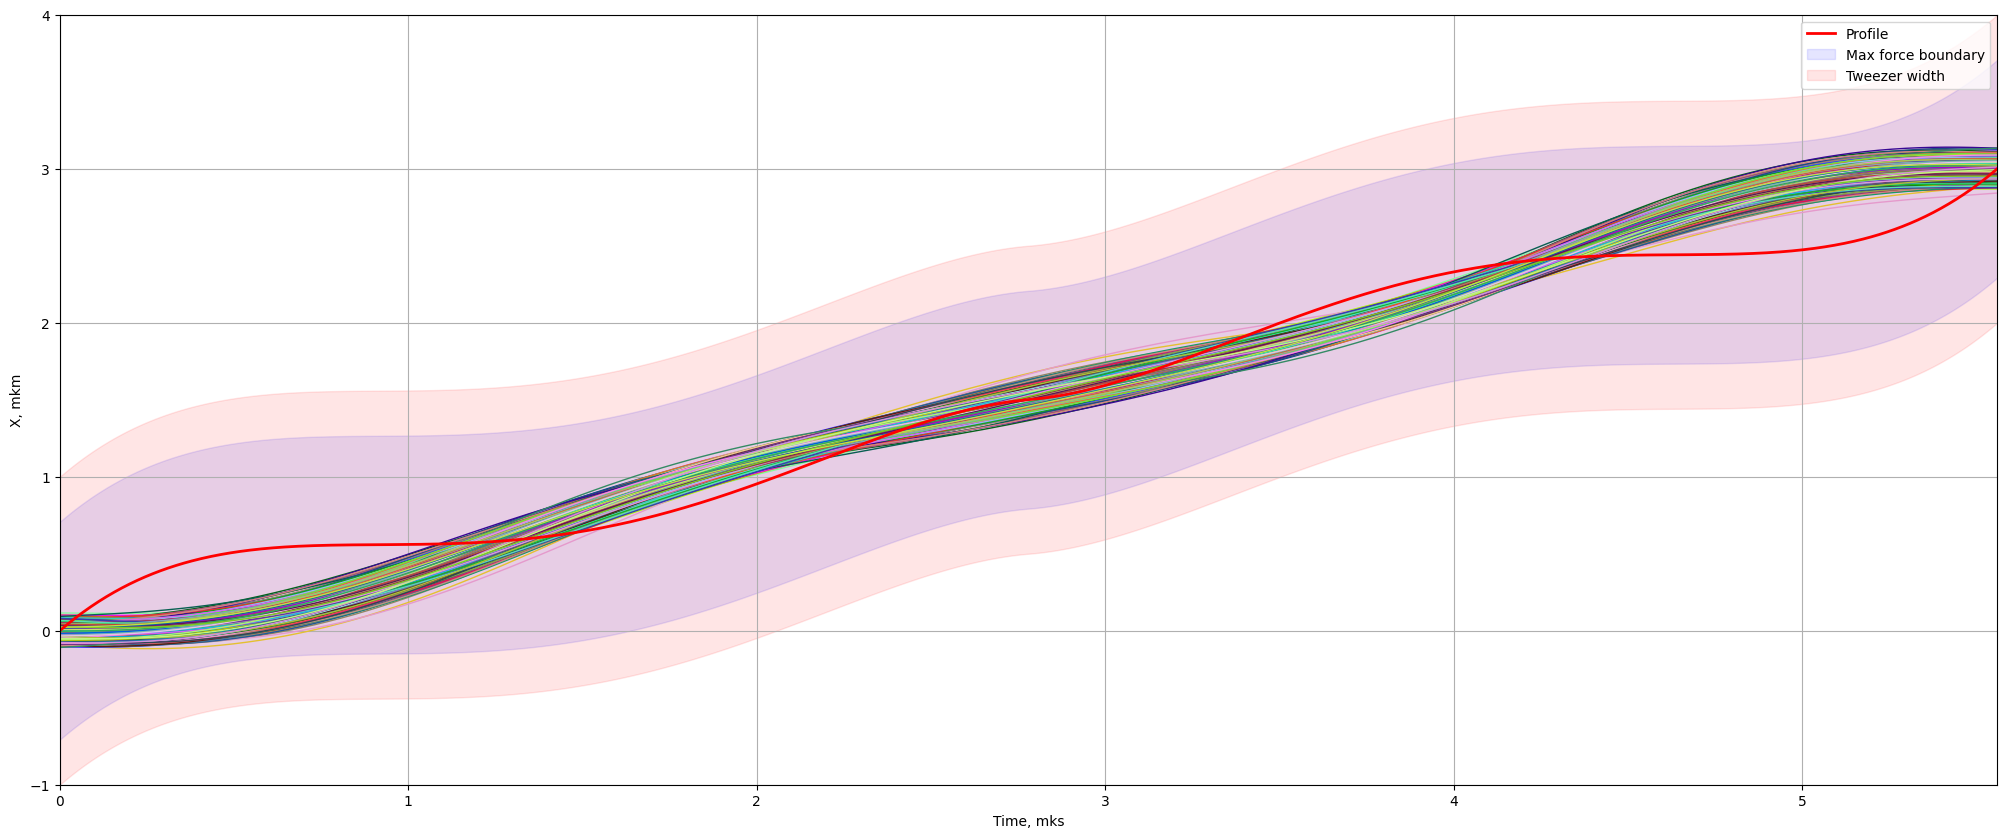

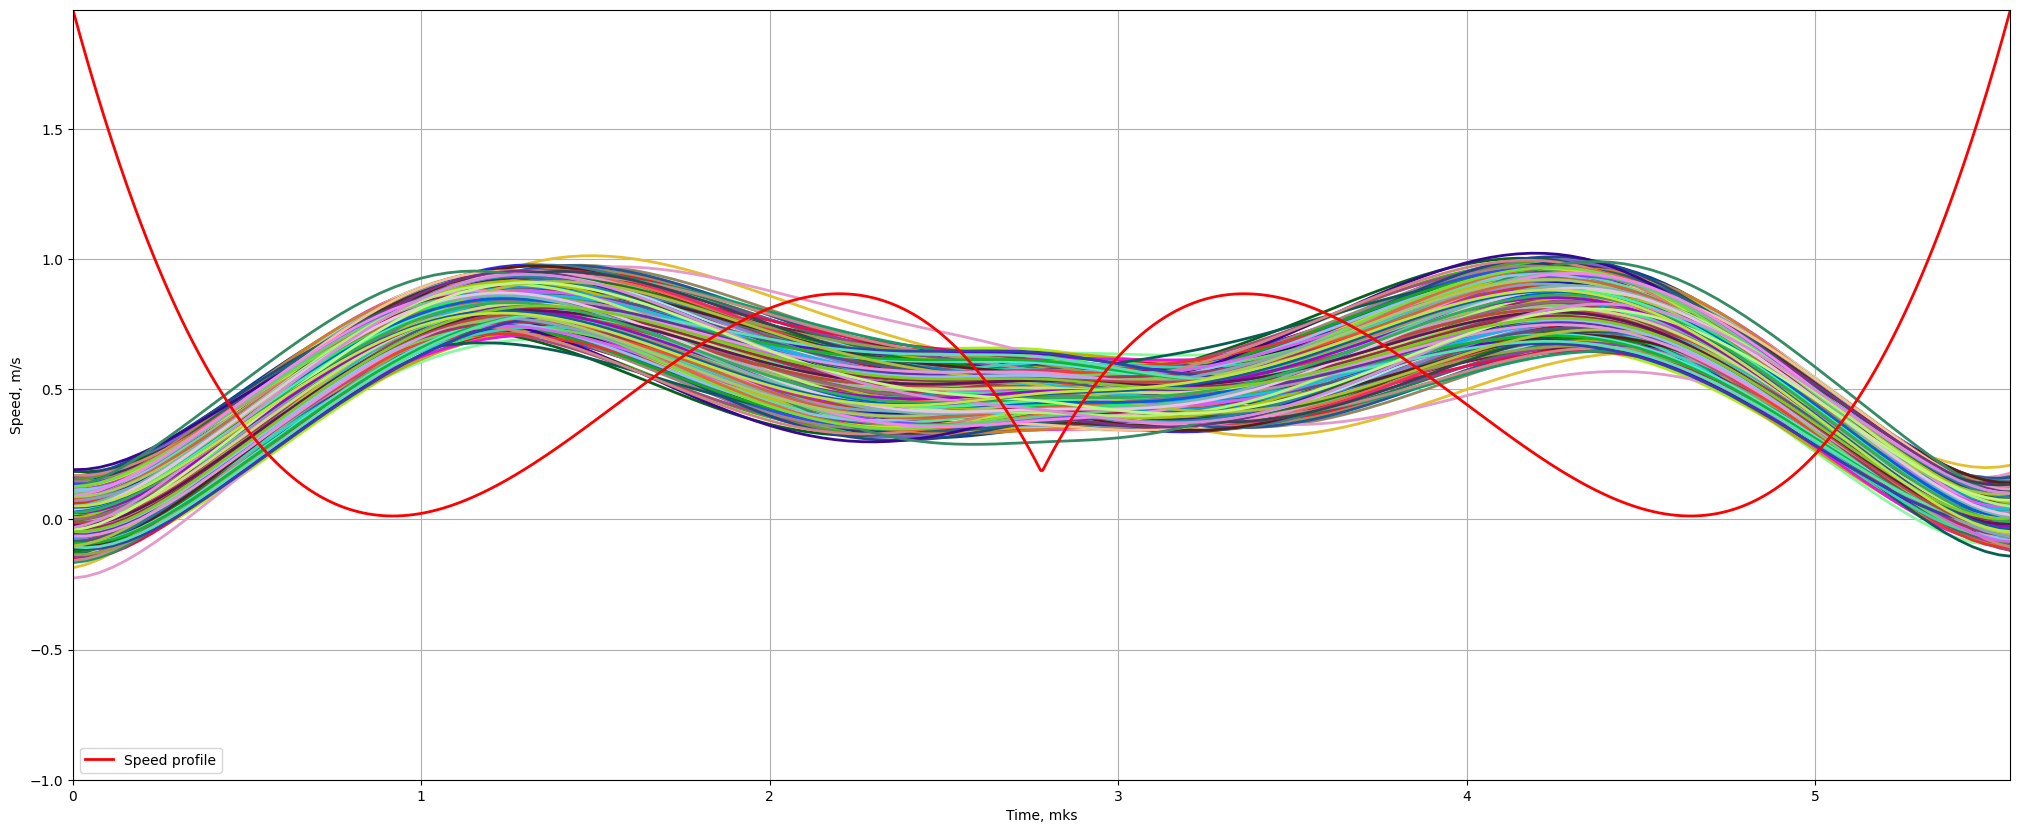

T = 35 mkK
Tend = 11.281664247371879 mks
Avarage speed = 1.338455007071995 m/s
Polynomial coefficients = [5.254973, 14.922704, -30.819128, 13.995338]
Heating = 0.1864729600887235 % from start average energy


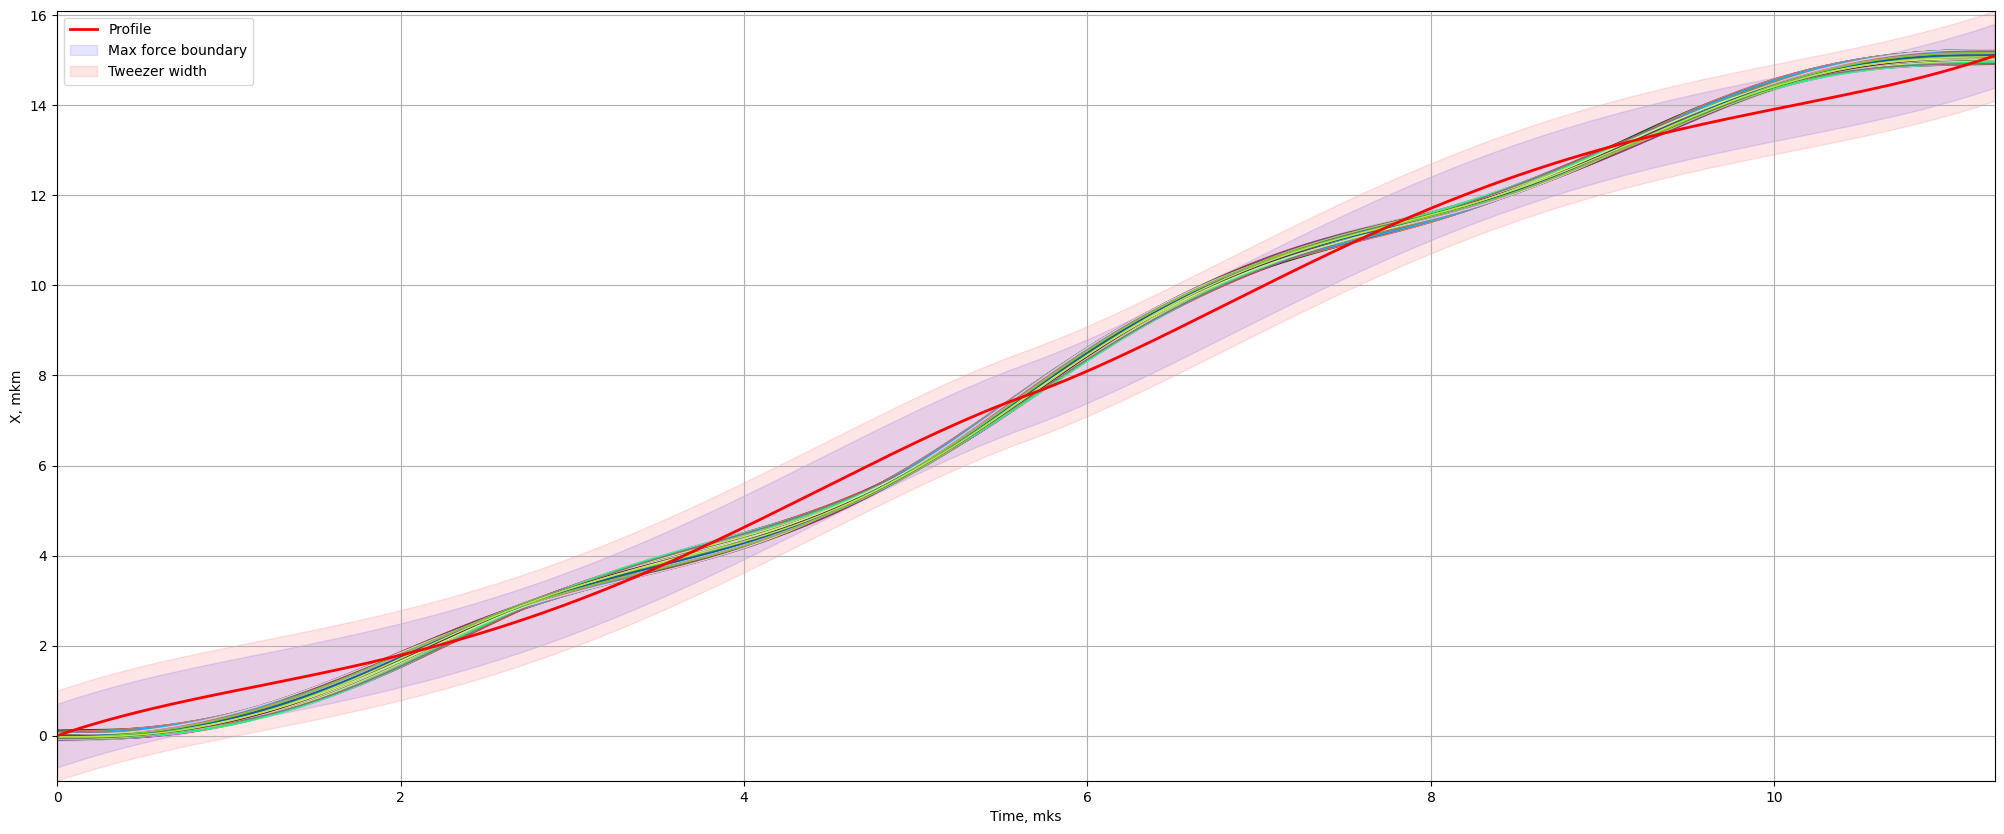

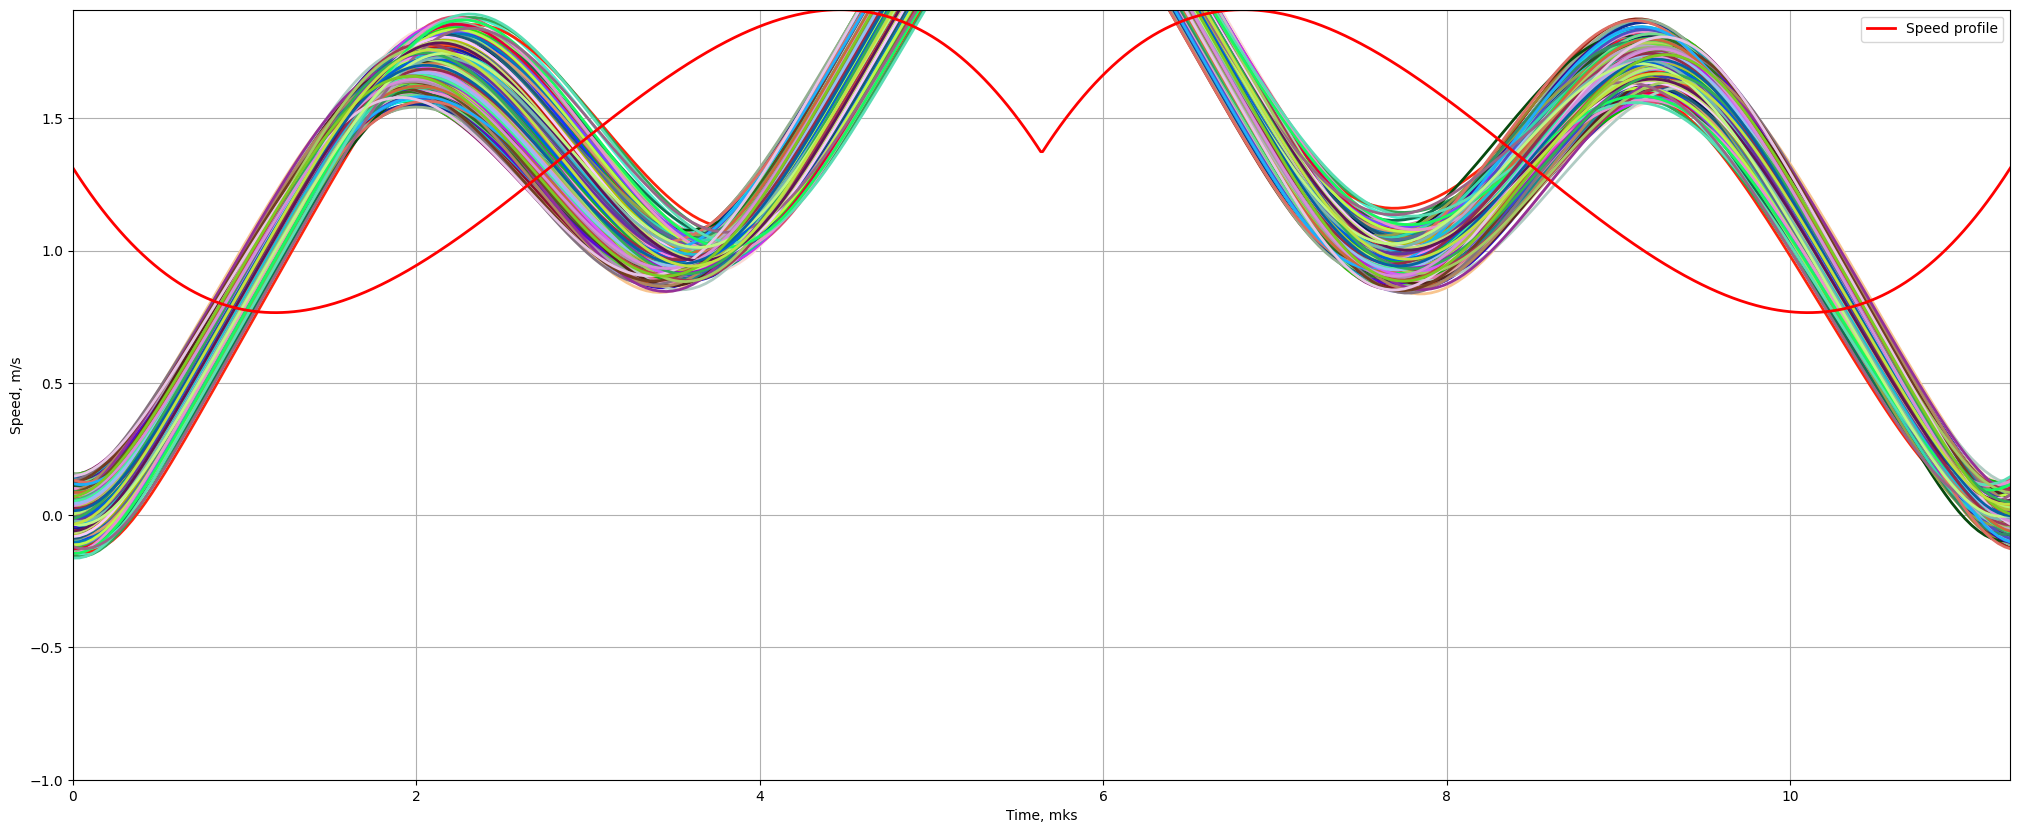

In [ ]:
get_graphs([3.000000,	1.448433, -39.478418, 1.000000, -38.157641, 0.691200, 38.850753, -168.382466, 176.389313],35, 0.22214414690791826, 0.035355339059327376)
get_graphs([15.10000, 2.938709, -39.478247, 1.000000, -37.695470, 5.254973, 14.922704, -30.8191280, 13.9953380],35, 0.22214414690791826, 0.035355339059327376)

T = 35 mkK
Tend = 5.560514767135363 mks
Avarage speed = 0.539518394543447 m/s
Polynomial coefficients = [0.6912, 38.850753, -168.382466, 176.389313]
Heating = 0.04351221447582348 % from start average energy


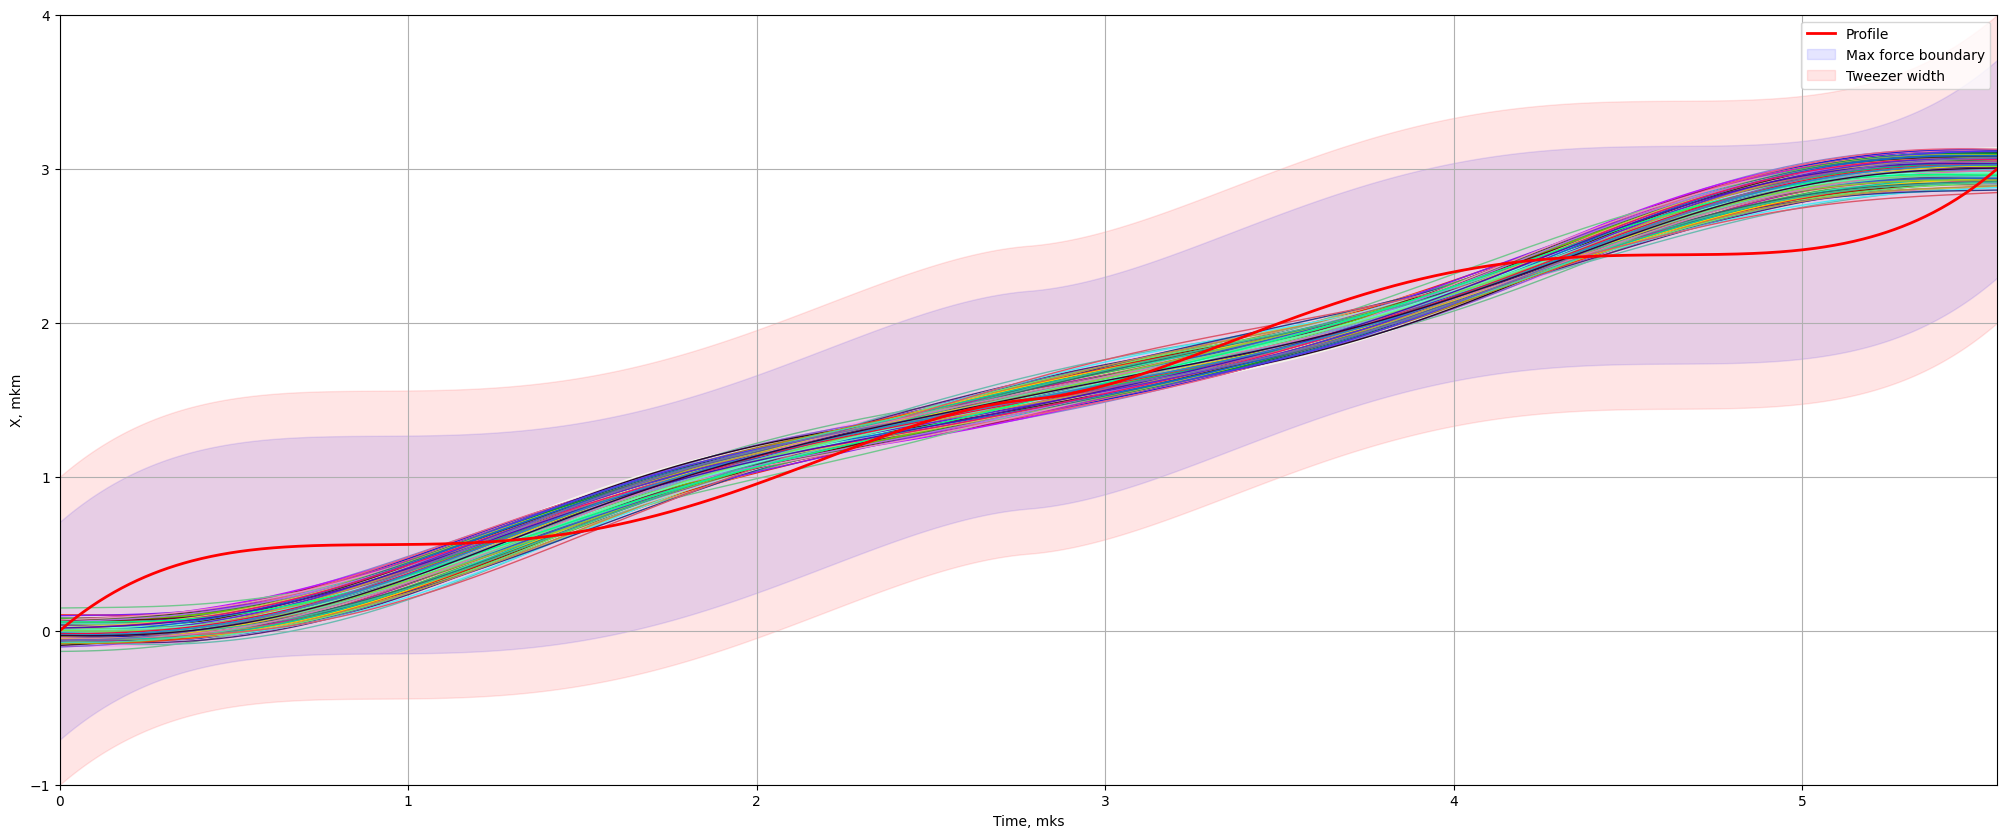

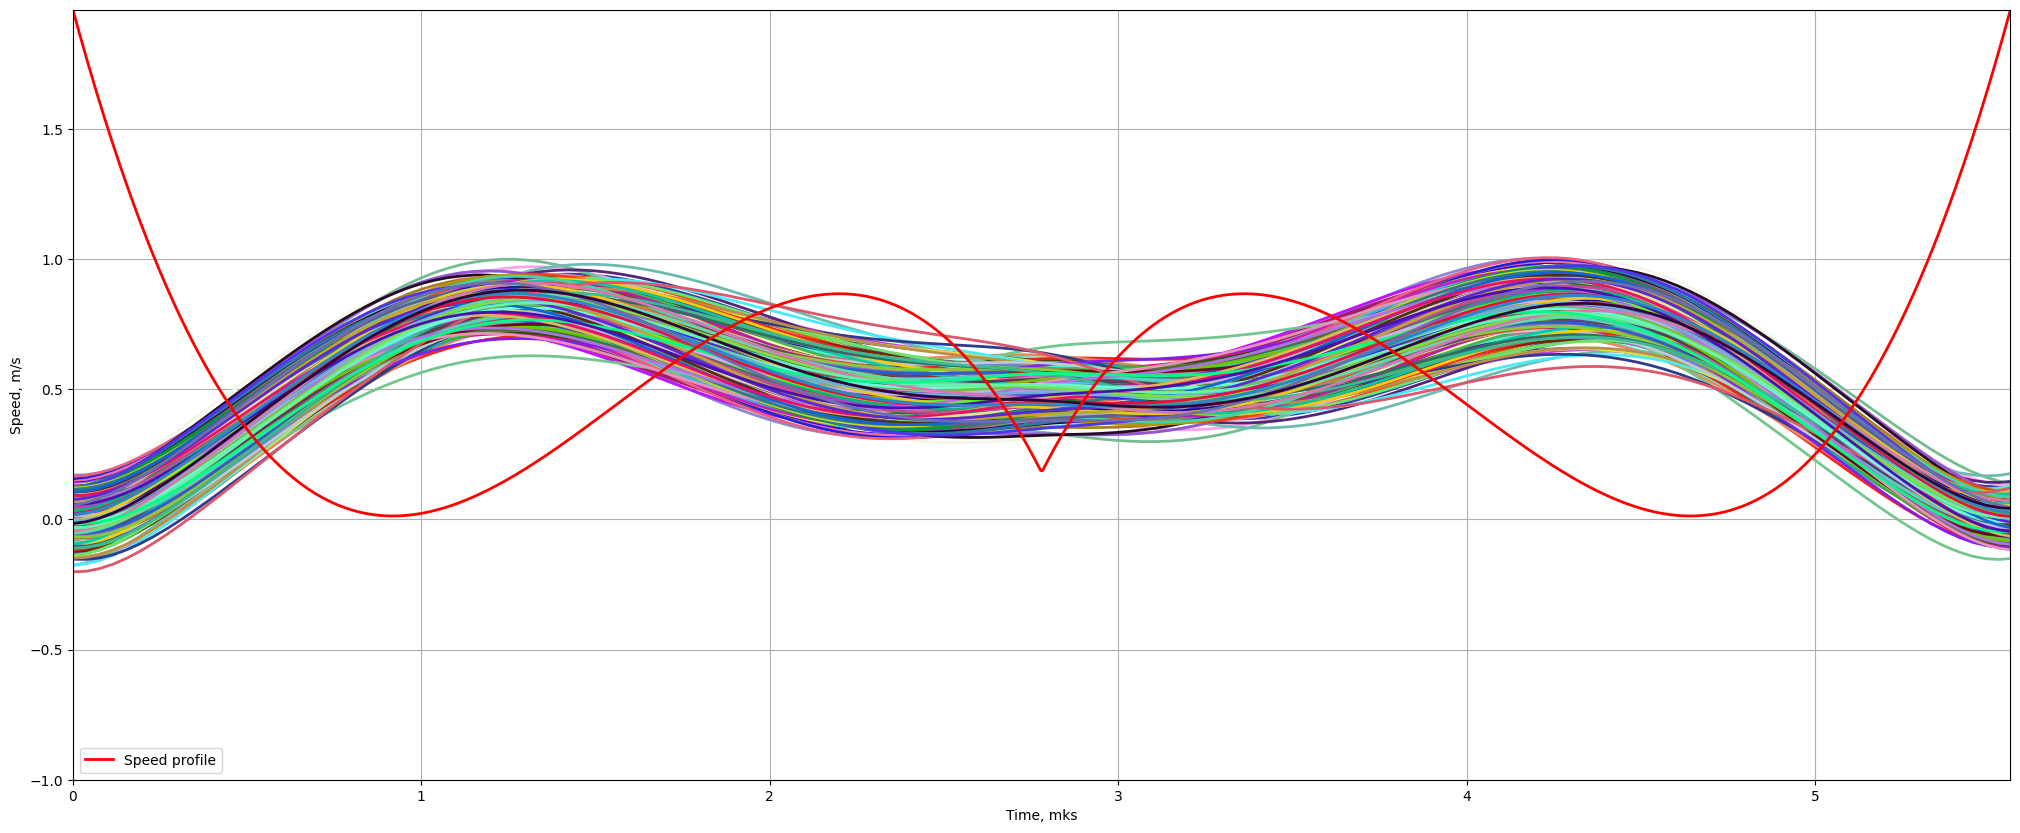

T = 35 mkK
Tend = 5.205926776895939 mks
Avarage speed = 0.5762662689214322 m/s
Polynomial coefficients = [1.335518, 37.569503, -186.262749, 214.089344]
Heating = 0.08591297146838915 % from start average energy


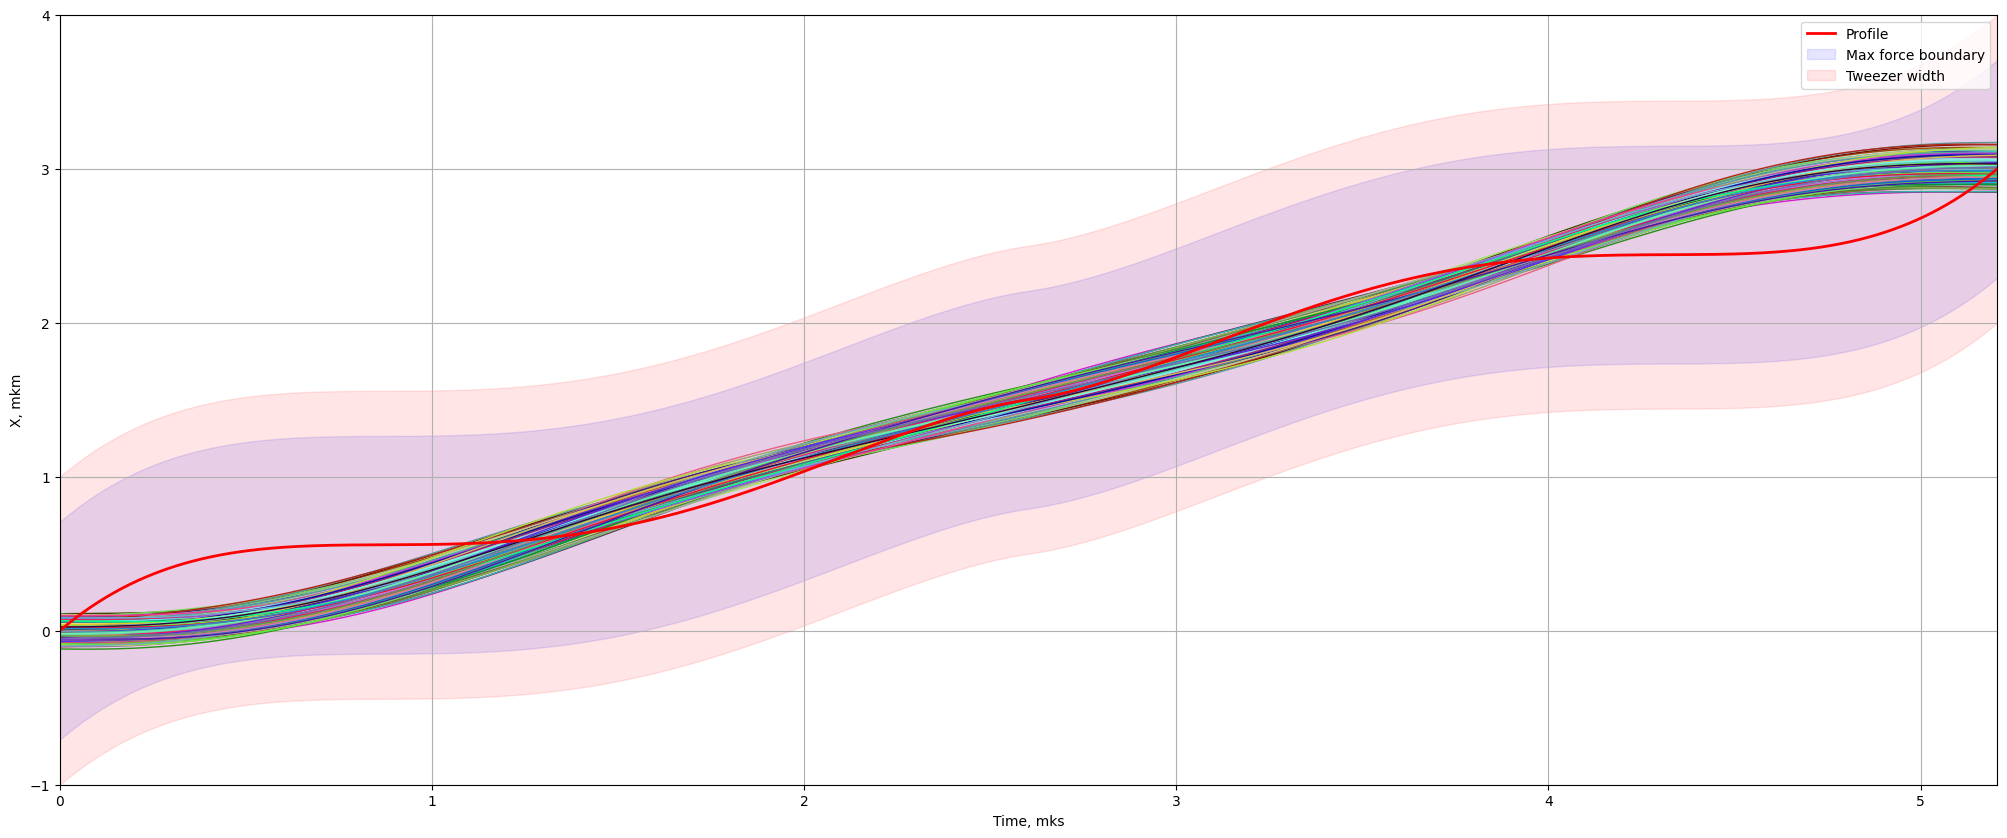

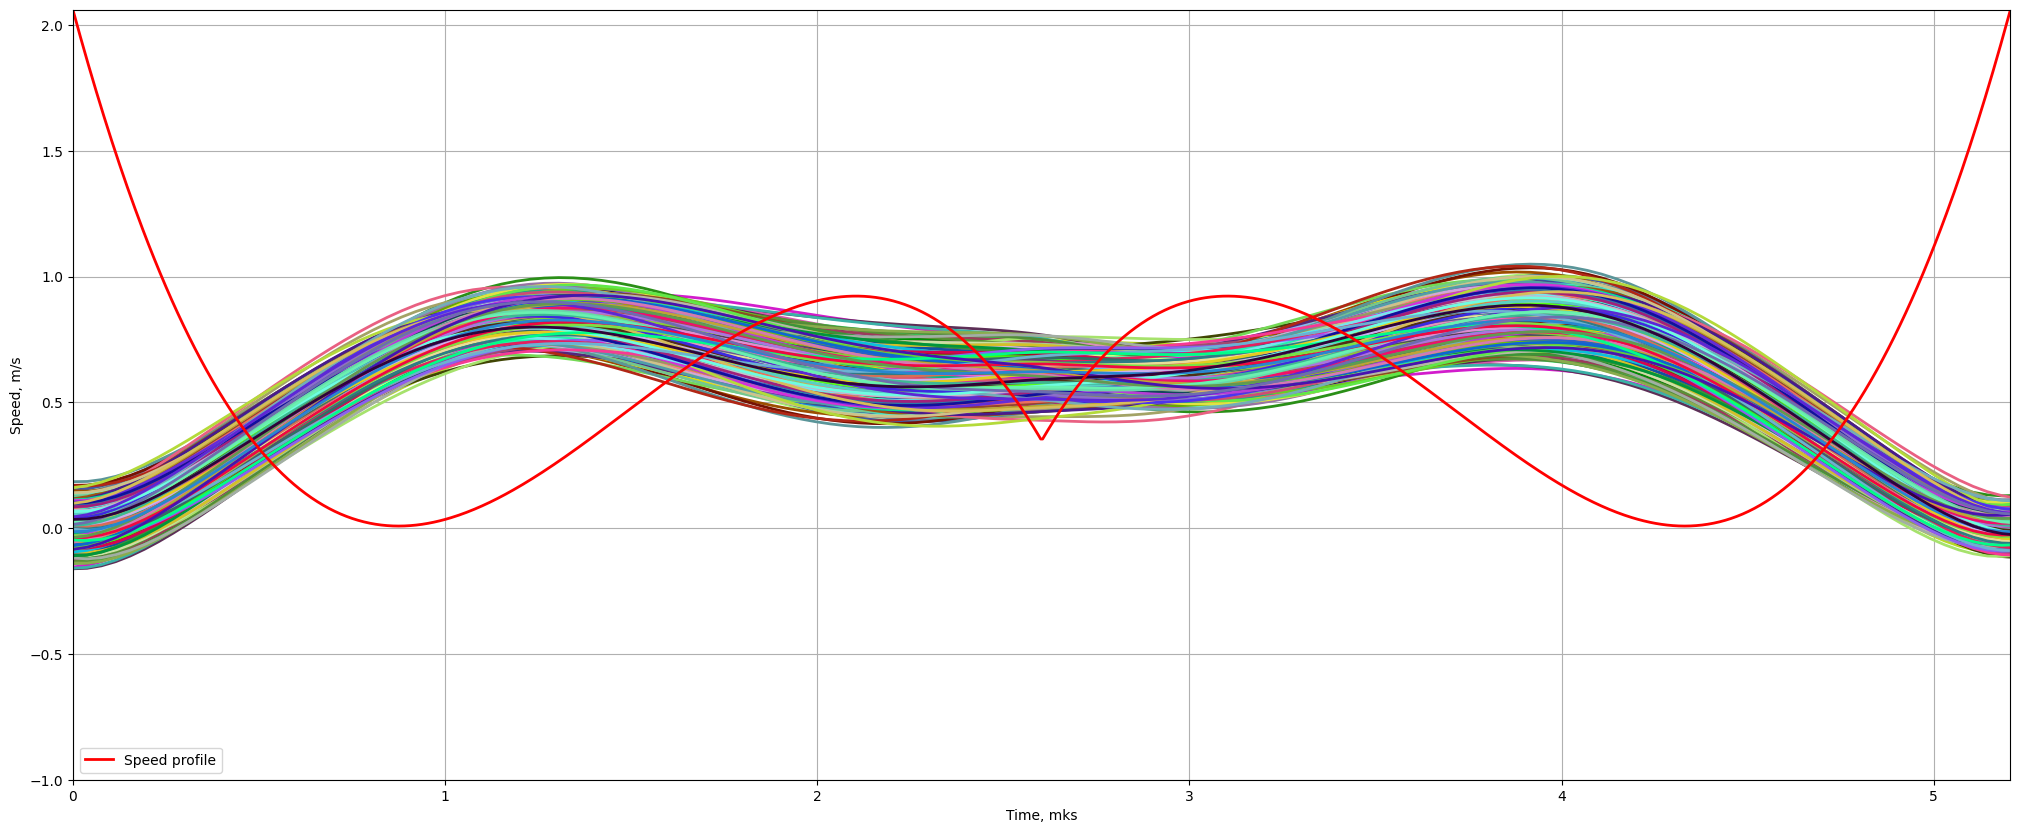

In [ ]:
get_graphs([3.000000,	1.448433, -39.478418, 1.000000, -38.157641, 0.691200, 38.850753, -168.382466, 176.389313],35, 0.22214414690791826, 0.035355339059327376)
get_graphs([3.000000, 1.356068, -39.478418, 1.000000, -38.413415, 1.335518, 37.569503, -186.262749, 214.089344],35, 0.22214414690791826, 0.035355339059327376)

In [ ]:
file = open('results_sorted.txt','r')
data = []
for line in file:
        data.append([float(x) for x in line.split()])
file.close()
print(len(data))
data = sorted(data, key = lambda x:x[0])

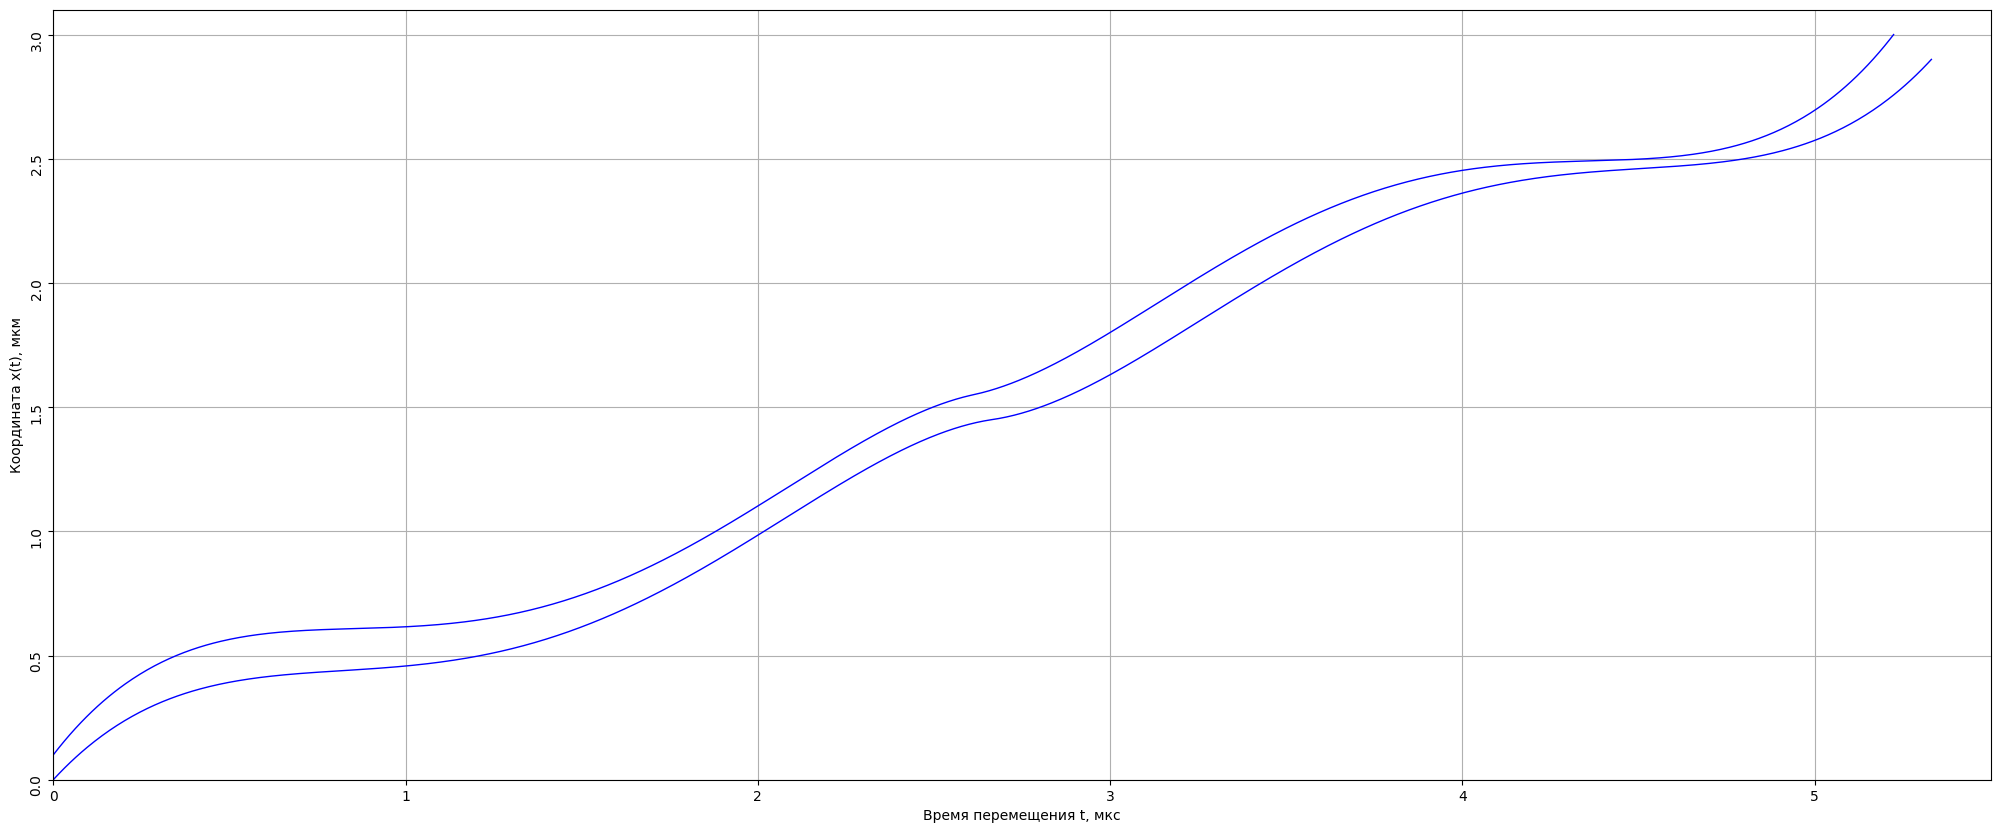

In [ ]:
plt.figure(figsize=(25,10))
i=0
for data_vector in data:
    vector = [data_vector[i]*2.9/data_vector[0] for i in range(5,len(data_vector))]

    #create t array
    t = []
    to = 0
    tau = 0.01
    t.append(to)
    while to < data_vector[1]:
            tau = min(tau, data_vector[1] - to)
            tau = float(tau)
            to = to + tau
            t.append(to)

    #Profile
    t = np.array([element * 3.838986523460431 for element in t])
    time_P = np.linspace(0,float(data_vector[1]),1000)
    y_P = np.array([Polynome(time,vector,data_vector[1],data_vector[0]) for time in time_P])
    #y_dP = np.array([dPolynome(time,vector,data_vector[1]) for time in time_P]) / 3.838986523460431
    time_P = time_P * 3.838986523460431
    
    #Plot graphs
    plt.plot(time_P, y_P, linewidth=1, color='blue')
    i+=1
    if(i==2): break
    

plt.xlim([0, 5.5])
plt.ylim([0, 3.1])
plt.xlabel("Время перемещения t, мкс")
plt.ylabel("Координата x(t), мкм")
plt.yticks(rotation=90)
#plt.legend()
plt.grid()
plt.show()

In [ ]:
#Initialize Profile
vector = [data_vector[i] for i in range(5,len(data_vector))]
print("Polynomial coefficients = " + str(vector))


#create t array
t = []
to = 0
tau = 0.01
t.append(to)
while to < data_vector[1]:
        tau = min(tau, data_vector[1] - to)
        tau = float(tau)
        to = to + tau
        t.append(to)

#Print heating
Energy_start = []
Energy_stop = []
for i in range(N):
    Energy_start.append(energy_start(y_res[i],t,data_vector[1],data_vector[0],vector))
    Energy_stop.append(energy_stop(y_res[i],t,data_vector[1],data_vector[0],vector))

print("Heating = " + str(get_heating(data_vector[0],t,data_vector[1],N,y_res,vector)) + " % from start average energy")

#Profile
t = np.array([element * 3.838986523460431 for element in t])
time_P = np.linspace(0,float(data_vector[1]),1000)
y_P = np.array([Polynome(t,vector,data_vector[1],data_vector[0]) for t in time_P])
y_dP = np.array([dPolynome(t,vector,data_vector[1]) for t in time_P]) / 3.838986523460431
time_P = time_P * 3.838986523460431


#Plot graphs
plt.figure(figsize=(12,5));
for i in range(N):
    plt.plot(t, Y_res[i], linewidth=0.3, color=colors[i])
plt.plot(time_P, y_P, linewidth=2, color='blue', label='Траектория центра пинцета')
plt.xlim([0, t[-1]])
plt.ylim([-1, max(8,max(y_P))+1])
#plt.fill_between(time_P, y_P + 1 / np.sqrt(2), y_P - 1 / np.sqrt(2), color='blue', alpha=0.1, label='Область между Fmax')
plt.fill_between(time_P, y_P + 1, y_P - 1, color='red', alpha=0.1, label='Ширина пинцета w=1мкм')
plt.xlabel("Время перемещения t, мкс")
plt.ylabel("Координата x(t), мкм")
plt.yticks(rotation=90)
plt.legend()
plt.grid()
#plt.savefig("coordinate.png",dpi=600)
#files.download("coordinate.png")
plt.show()

plt.figure(figsize=(6,4));
for i in range(N):
    plt.plot(t, dY_res[i], linewidth=2, color=colors[i])
plt.plot(time_P, y_dP, linewidth=2, color='blue', label='Профиль скорости')
plt.xlim([0, t[-1]])
plt.ylim([- 0.5, 3])
plt.xlabel("Время перемещения t, мкс")
plt.ylabel("Скорость V(t), м/с")
plt.yticks(rotation=90)
plt.legend()
plt.grid()
#plt.savefig("profile.png",dpi=600)
#files.download("profile.png")
plt.show()